In [ ]:
import numpy as np
import pandas as pd
import nltk
import re
nltk.download('wordnet')
nltk.download('stopwords')


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##### For IMDB dataset #######
#!unzip /content/IMDB\ Dataset.csv.zip -d /content
df = pd.read_csv("/content/drive/MyDrive/nlp datasets/IMDB Dataset.csv")
print(df.head())
def label_to_int(label):
  if label == "positive":
    return 1
  else:
    return  0

df['sentiment'] = df['sentiment'].apply(label_to_int)
n_classes = 2 

##### For AGNEWS dataset
'''
df = pd.read_csv("/content/drive/MyDrive/nlp datasets/AGNEWS.csv")
print(df.head())
print(np.unique(df['sentiment']))
def label_(label):
    return  label-1
df['sentiment'] = df['sentiment'].apply(label_)
print(np.unique(df['sentiment']))
n_classes = 4'''

##### For TREC-6 dataset
'''
df = pd.read_csv("/content/drive/MyDrive/nlp datasets/TREC-6.csv")
print(df.head())
print(np.unique(df['sentiment']))
def label_to_int(label):
  if label == 'ABBR':
    return 0
  if label == 'DESC':
    return 1
  if label == 'ENTY':
    return 2
  if label == 'HUM':
    return 3
  if label == 'LOC':
    return 4
  if label == 'NUM':
    return 5

df['sentiment'] = df['sentiment'].apply(label_to_int)
n_classes = 6
print(np.unique(df['sentiment']))'''

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


'\ndf = pd.read_csv("/content/drive/MyDrive/nlp datasets/TREC-6.csv")\nprint(df.head())\nprint(np.unique(df[\'sentiment\']))\ndef label_to_int(label):\n  if label == \'ABBR\':\n    return 0\n  if label == \'DESC\':\n    return 1\n  if label == \'ENTY\':\n    return 2\n  if label == \'HUM\':\n    return 3\n  if label == \'LOC\':\n    return 4\n  if label == \'NUM\':\n    return 5\n\ndf[\'sentiment\'] = df[\'sentiment\'].apply(label_to_int)\nn_classes = 6\nprint(np.unique(df[\'sentiment\']))'

In [ ]:
test_size = 0.1
from sklearn.model_selection import train_test_split
corpus_train, corpus_test = train_test_split(df , test_size=test_size, stratify=df['sentiment'])
corpus_train, corpus_dev = train_test_split(corpus_train, train_size=.9, stratify=corpus_train['sentiment'])
corpus_train, corpus_ul = train_test_split(corpus_train , train_size=200, stratify=corpus_train['sentiment'])
print(len(corpus_train))
print(len(corpus_dev))
print(len(corpus_ul))
print(len(corpus_test))

200
4500
40300
5000


In [ ]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
def normalize_document(doc):

    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    doc = doc.replace('"',"")

    # tokenize document
    tokens = wpt.tokenize(doc)

    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # re-create document from filtered tokens
    return " ".join(filtered_tokens)

In [ ]:
#corpus_dev['review'] = corpus_dev['review'].apply(normalize_document)
#corpus_train['review'] = corpus_train['review'].apply(normalize_document)

In [ ]:
corpus_dev['review'].iloc[5]

"How long was Mao 's 1930s Long March ?\r\n"

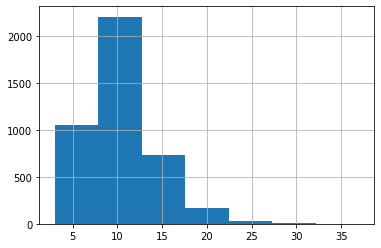

In [ ]:
seq_len = [len(i.split()) for i in corpus_ul['review']]
pd.Series(seq_len).hist(bins = 7)

In [ ]:
!pip3 install transformers

     |████████████████████████████████| 1.8MB 18.7MB/s 
     |████████████████████████████████| 890kB 55.3MB/s 
     |████████████████████████████████| 2.9MB 57.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=8221075651d5f637847703444c87db0ab81c648cba7fa75601ae9fd5eab1c49b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import transformers
from transformers import AdamW
from transformers import BertModel, BertTokenizer

bert = BertModel.from_pretrained('bert-base-uncased')
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_TOKENS = 250

In [ ]:
tr = list(corpus_train['review'])
vl = list(corpus_dev['review'])
ul = list(corpus_ul['review'])

In [ ]:
print(vl[5])

What dummy received an honorary degree from Northwestern University ?



In [ ]:
test = tokenizer(tr[0])
input_ids = torch.tensor(test['input_ids']).unsqueeze(0)
input_mask = torch.tensor(test['attention_mask']).unsqueeze(0)
print(input_ids.shape, input_mask.shape)
bert.eval()
_,out1 = bert(input_ids,input_mask,return_dict=False)   
_,out2 = bert(input_ids,input_mask,return_dict=False) 

torch.Size([1, 198]) torch.Size([1, 198])


In [ ]:
tokens_train = tokenizer(
    tr,
    padding = True,
    max_length = MAX_TOKENS,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_dev = tokenizer(
    vl,
    padding = True,
    max_length = MAX_TOKENS,
    truncation=True
)

tokens_ul = tokenizer(
    ul,
    padding = True,
    max_length = MAX_TOKENS,
    truncation=True
)

In [ ]:
print(tokenizer.decode(tokens_ul['input_ids'][5]))

[CLS] what european country boasts the city of furth, found where the rivers rednitz and peg [SEP]


In [ ]:
print(len(tokens_train['input_ids'][0]))

20


In [ ]:
a = list(corpus_train['sentiment'])
b = list(corpus_dev['sentiment'])
print(a)

[2, 1, 1, 1, 1, 2, 2, 2, 1, 4, 3, 3, 3, 3, 4, 1, 5, 1, 3, 5, 4, 2, 1, 5, 4, 3, 1, 5, 5, 2, 3, 2, 2, 5, 2, 4, 1, 3, 5, 5, 1, 4, 3, 1, 5, 0, 3, 1, 3, 3, 2, 1, 2, 2, 1, 4, 3, 5, 5, 3, 4, 2, 4, 5, 2, 4, 5, 5, 5, 4, 1, 5, 3, 4, 4, 5, 4, 3, 4, 5, 1, 1, 5, 2, 1, 3, 2, 2, 4, 3, 1, 4, 4, 4, 5, 3, 2, 2, 3, 3, 4, 2, 1, 2, 3, 1, 1, 1, 3, 3, 3, 3, 3, 2, 4, 0, 4, 2, 3, 3, 2, 3, 3, 1, 2, 2, 5, 2, 5, 3, 2, 5, 3, 3, 1, 2, 2, 1, 1, 2, 2, 3, 5, 3, 4, 3, 1, 0, 3, 1, 1, 1, 1, 4, 5, 1, 1, 4, 1, 2, 2, 2, 2, 5, 3, 4, 2, 1, 2, 4, 4, 4, 5, 1, 5, 5, 3, 1, 1, 2, 3, 1, 2, 5, 2, 5, 4, 3, 2, 3, 3, 1, 5, 2, 2, 2, 1, 2, 5, 3]


In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(a)

dev_seq = torch.tensor(tokens_dev['input_ids'])
dev_mask = torch.tensor(tokens_dev['attention_mask'])
dev_y = torch.tensor(b)

ul_seq = torch.tensor(tokens_ul['input_ids'])
ul_mask = torch.tensor(tokens_ul['attention_mask'])

print(dev_seq.shape)
print(train_seq.shape)
print(ul_seq.shape)

torch.Size([491, 20])
torch.Size([200, 20])
torch.Size([4215, 20])


In [ ]:
print(ul_seq.shape)
print(ul_mask.shape)

torch.Size([4215, 20])
torch.Size([4215, 20])


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 64

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
dev_data = TensorDataset(dev_seq, dev_mask, dev_y)
# sampler for sampling the data during training
dev_sampler = SequentialSampler(dev_data)
# dataLoader for validation set
dev_dataloader = DataLoader(dev_data, sampler = dev_sampler, batch_size=batch_size)

# wrap tensors
ul_data = TensorDataset(ul_seq, ul_mask)
# sampler for sampling the data during training
ul_sampler = RandomSampler(ul_data)
# dataLoader for train set
ul_dataloader = DataLoader(ul_data, sampler=ul_sampler, batch_size=batch_size)

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class Encoder_Classifier(nn.Module):
    def __init__(self, bert, n_classes):
      super(Encoder_Classifier, self).__init__()
      self.bert = bert
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,n_classes)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      
      x = self.fc1(cls_hs) 
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
def train(weight):
  model.train()

  total_celoss, total_mseloss, total_accuracy = 0, 0,0
  '''
  # empty list to save model predictions
  total_preds=[]'''
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # push the batch to gpu
    #batch = [r.to(device) for r in batch]
    
    ###### for  labeled data, computing cross entropy   #########
    sent_id, mask, labels = batch[0].to(device),batch[1].to(device),batch[2].to(device)

    model.zero_grad()        
    preds = model(sent_id, mask)
    celoss = CELoss(preds, labels)


    _,batch = next(enum_unlabeled_loader)
    sent_id, mask =  batch[0].to(device),batch[1].to(device)
    preds1 = model(sent_id, mask)
    preds2 = model(sent_id, mask)

    mseloss = MSELoss(preds1,preds2)

    # backward pass to calculate the gradients
    finalloss = celoss + weight * mseloss
    finalloss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # add on to the total loss
    loss_item = finalloss.item()

    # progress update after every 5 batches.
    if step % 5 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
      print("loss",loss_item)

    total_celoss = total_celoss + celoss.item()
    total_mseloss = total_mseloss + mseloss.item()

    '''
    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)'''

  # compute the training loss of the epoch
  avg_celoss = total_celoss / len(train_dataloader)
  avg_mseloss = total_mseloss / len(train_dataloader)
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  #total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_celoss, avg_mseloss

In [ ]:
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()
  total_loss, total_accuracy = 0, 0
  total_preds = []
  count=0

  # iterate over batches
  for step,batch in enumerate(dev_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dev_dataloader)))

    # push the batch to gpu
    #batch = [t.to(device) for t in batch]
    

    sent_id, mask, labels = batch[0].to(device),batch[1].to(device),batch[2].to(device)

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = CELoss(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

      true_class = np.argmax(preds,axis=1)
      for myvar in range(len(labels)):
        if labels[myvar]== true_class[myvar]:
          count+=1

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(dev_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  print("Validation accuracy",count/len(dev_data))

  return avg_loss, count/len(dev_data)

In [ ]:
best_valid_loss = float('inf')
train_losses = []
valid_losses = []
accuracy_list = []
learning_rate = .0005
freezed_epochs = 15
n_layer_unfreeze = 2
weight = .3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CELoss = nn.CrossEntropyLoss()
MSELoss = nn.MSELoss()
model = Encoder_Classifier(bert, n_classes).to(device)
optimizer = AdamW(model.parameters(),lr = learning_rate)

In [ ]:

#for each epoch
for epoch in range(freezed_epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, freezed_epochs))
    
    #train model
    enum_unlabeled_loader = enumerate(ul_dataloader)
    train_loss = train(weight)
    
    #evaluate model
    valid_loss, accuracy = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    accuracy_list.append(accuracy)

    print(f'\nTraining Loss: {train_loss[0]:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

##### unfreezing layers #######
for iter in range(n_layer_unfreeze):
    print(str(iter+1)+" unfreeze")
    for param in model.bert.encoder.layer._modules[str(11-iter)].parameters():
        param.requires_grad=True
    for epoch in range(2):
     
        print('\n Epoch {:} / {:}'.format(epoch + 1, 2))
        
        #train model
        
        enum_unlabeled_loader = enumerate(ul_dataloader)
        train_loss = train(weight)
        
        #evaluate model
        valid_loss, accuracy = evaluate()
        
        #save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'saved_weights.pt')
        
        # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        accuracy_list.append(accuracy)
        
        print(f'\nTraining Loss: {train_loss[0]:.3f}')
        print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 15

Evaluating...
Validation accuracy 0.20162932790224034

Training Loss: 1.753
Validation Loss: 1.699

 Epoch 2 / 15

Evaluating...
Validation accuracy 0.219959266802444

Training Loss: 1.671
Validation Loss: 1.680

 Epoch 3 / 15

Evaluating...
Validation accuracy 0.19959266802443992

Training Loss: 1.651
Validation Loss: 1.647

 Epoch 4 / 15

Evaluating...
Validation accuracy 0.219959266802444

Training Loss: 1.625
Validation Loss: 1.658

 Epoch 5 / 15

Evaluating...
Validation accuracy 0.2240325865580448

Training Loss: 1.626
Validation Loss: 1.658

 Epoch 6 / 15

Evaluating...
Validation accuracy 0.26883910386965376

Training Loss: 1.624
Validation Loss: 1.635

 Epoch 7 / 15

Evaluating...
Validation accuracy 0.28716904276985744

Training Loss: 1.586
Validation Loss: 1.629

 Epoch 8 / 15

Evaluating...
Validation accuracy 0.27494908350305497

Training Loss: 1.602
Validation Loss: 1.626

 Epoch 9 / 15

Evaluating...
Validation accuracy 0.285132382892057

Training Loss: 1

In [ ]:
np.savetxt('/content/drive/MyDrive/nlp datasets/TREC-6_valloss.txt',valid_losses,delimiter = ",")
np.savetxt('/content/drive/MyDrive/nlp datasets/TREC-6_accuracy.txt',accuracy_list,delimiter = ",")